In [1]:
# Parte 1 - creo dataframe

import pandas as pd
from MJP.majority_portfolio_utilities_TV import * 

FILENAME = 'monthly_data.csv'
factors_df=pd.DataFrame({
    'factors': ['ag','beta','bm','cumret','dolvol6','gp','ill6','ns','size','volatility','acc'],
    'signs': [  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.],
    'wsigns':[  -1.,  1.,   1.,    1.,     -1.,     1.,    1.,  -1.,  -1.,   -1.,   -1.]
})

DATA_INIZIO = '2000-01-01'
DATA_FINE = '2023-12-31'

df = create_df(FILENAME, factors_df['factors'].tolist(), DATA_INIZIO, DATA_FINE) # funzione sua 
print(f"DataFrame caricato: {df.shape[0]:,} righe, {df.shape[1]} colonne")
print(df.columns.tolist())


DataFrame caricato: 1,099,846 righe, 19 colonne
['PERMNO', 'date', 'RET', 'ns', 'me', 'size', 'me_lag', 'ag', 'gp', 'acc', 'bm', 'RF', 'Mkt_RF', 'RET_RF', 'cumret', 'dolvol6', 'ill6', 'volatility', 'beta']


In [2]:
from sklearn.preprocessing import QuantileTransformer

factors_to_normalize = ['ns', 'size', 'ag', 'gp', 'acc', 'bm', 'ill6', 'volatility', 'beta']

# Elimina righe con NaN solo nelle colonne da normalizzare
df_clean = df.dropna(subset=factors_to_normalize)

# Applica Quantile normalization solo ai fattori
scaler = QuantileTransformer(output_distribution='uniform', random_state=0)
df_norm = df_clean.copy()
df_norm[factors_to_normalize] = scaler.fit_transform(df_clean[factors_to_normalize])

print("✅ df normalizzato su fattori:")
df_norm.head()


✅ df normalizzato su fattori:


,PERMNO,date,RET,ns,me,size,me_lag,ag,gp,acc,bm,RF,Mkt_RF,RET_RF,cumret,dolvol6,ill6,volatility,beta
0,10001,2000-01-31,-0.044118,0.552123,19.90625,0.089730,20.82500,0.429226,0.186763,0.098351,0.751966,0.0041,-0.0474,-0.048218,-0.066220,3862.520833,0.868132,0.039530,0.100142
1,10001,2000-02-29,0.015385,0.552123,20.21250,0.090958,19.90625,0.429226,0.186763,0.098351,0.746500,0.0043,0.0245,0.011085,-0.018159,3476.520833,0.875944,0.018688,0.100379
2,10001,2000-03-31,-0.015758,0.619632,19.71200,0.088813,20.21250,0.429226,0.186763,0.098351,0.754909,0.0047,0.0520,-0.020458,-0.015986,3445.854167,0.864058,0.018764,0.102204
3,10001,2000-04-30,0.011719,0.619632,19.94300,0.089905,19.71200,0.429226,0.186763,0.098351,0.751315,0.0046,-0.0640,0.007119,-0.045133,3282.276042,0.822586,0.018568,0.096001
4,10001,2000-05-31,-0.023166,0.619632,19.48100,0.087670,19.94300,0.429226,0.186763,0.098351,0.759141,0.0050,-0.0442,-0.028166,-0.013093,2921.385417,0.850747,0.018772,0.100983


In [3]:
# Parte 3 - inizializzazione della configurazione

remove_outliers = False
inf, sup = None, None
MJ_configuration={
    'K' : 12, # holding_periods in months
    'lag' : 5, # 5 for june reallocation
    'factors' : factors_df['factors'].to_list(),
    'num_port' : 10, # number of portfolios
    'num_cat' : 6, # number of categorical variables to use per factor in mj #'num_cat': 6
    'weighting': False,
    'verbose': True,
    'n_jobs':-1,
    'mj_window':1,
    'method' : 'majority', # mean_rank, majority, 75q, 90q, lex, dlex
    'rolling_method':'profile',  ###'rank','vote','profile'
    'treat_na_mj':'median',
    'remove_outliers':remove_outliers,
    'inclusive':True,
    'fix_signs':True, # True: tieni fisso il numero di votanti ed il loro segno
    'all_voters_not_nan_on_reallocation':True,
    #### PARAMETRI UTILIZZATI SOLO SE fix_signs=False ####
    'min_voters':5,    
    'voting_window':6,
    'sign_voting_window':12,
    'p_threshold' : 0.1, 
    'delta_utility' : 0,
    'eliminations': 1,
    'players_batch_size': 5,
    'small': True
}
if remove_outliers:
    MJ_configuration['outliers']=[inf,sup]

if MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['wsigns'].to_list()
    compute='wmj'
elif not MJ_configuration['weighting']:
    MJ_configuration['default_voters']=factors_df['factors'].to_list()
    MJ_configuration['default_signs']=factors_df['signs'].to_list()
    compute='mj'

factors=factors_df['factors'].to_list() # salva separatamente la lista dei nomi dei fattori 

In [4]:
# Parete 4 - creazione portafogli single criteria e mj

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

### COMPUTE SINGLE FACTOR STRATEGIES
portfolios, _, portfolios_stock_reallocation = compute_factor_strategies(df_norm, MJ_configuration)
        # '2020-06-30': [list of tickers]       # Con pesi, uguale ma 'AAPL': 0.1           # 'AAPL': 2020-06-30': 'P3', '2021-06-30': 'P5'}
        # '2021-06-30': [list of tickers]
        # _ perché non considero weighted_portfolios al momento

### COMPUTE EQUAL WEIGHTED MJ STRATEGY
MJ_configuration['weighting']=False
MJ_portfolios, \
mj_voters, \
MJ_portfolios_stock_reallocation = compute_MJ_portfolio_strategy(df_norm, 
                                                            MJ_configuration)
portfolios['mj'] = MJ_portfolios['mj']
portfolios_stock_reallocation['mj'] = {}
portfolios_stock_reallocation['mj']['EW_turnover'] = MJ_portfolios_stock_reallocation['mj']

'''
OUTPUT: 
portfolios = {
  'ns': DataFrame con port1...port10 costruiti su ns,
  'beta': ...,
  'bm': ...,
  ...
  'mj': DataFrame con port1...port10 creati con MJ
}
'''


/home/nitro/tirocinio/Tirocinio_mcdm/mcdm_4crit/VG/MJP/majority_portfolio_utilities_TV.py:90: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '<DatetimeArray>
['2000-01-31 00:00:00', '2000-02-29 00:00:00', '2000-03-31 00:00:00',
 '2000-04-30 00:00:00', '2000-05-31 00:00:00', '2000-06-30 00:00:00',
 '2000-07-31 00:00:00', '2000-08-31 00:00:00', '2000-09-30 00:00:00',
 '2000-10-31 00:00:00',
 ...
 '2023-03-31 00:00:00', '2023-04-30 00:00:00', '2023-05-31 00:00:00',
 '2023-06-30 00:00:00', '2023-07-31 00:00:00', '2023-08-31 00:00:00',
 '2023-09-30 00:00:00', '2023-10-31 00:00:00', '2023-11-30 00:00:00',
 '2023-12-31 00:00:00']
Length: 879673, dtype: datetime64[ns]' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  df.loc[:,'medate'] = df.loc[:,'date'].copy() + pd.offsets.MonthEnd(0)
/home/nitro/tirocinio/Tirocinio_mcdm/mcdm_4crit/VG/MJP/majority_portfolio_utilities_TV.py:90

"\nOUTPUT: \nportfolios = {\n  'ns': DataFrame con port1...port10 costruiti su ns,\n  'beta': ...,\n  'bm': ...,\n  ...\n  'mj': DataFrame con port1...port10 creati con MJ\n}\n"

Io creo un file di configurazione, in cui specifico numero di portafogli e fattori. 
Dopo di cio, passo la configurazione alla funzione compute_factor_strategy, creo i portafogli basati sul singolo criterio (10+1).

Dopo di questo, con la funzione seguente, creo i 10 portafogli + long-short basati su MJ (quindi tutti i criteri precedenti danno un voto per riassumere). 
Fatto cio, creo un dizionario con tutti i portafogli creati, a cui aggiungo i portafogli creati con MJ. 
Ad ogni criterio, sono associati 10 portafogli + 1 attraverso un dataset

Detto cio, plotto i 10+1 portafogli con 'ns', e dopo di cio faccio uguale con mj

Per quanto riguarda il turnover, una scritta del tipo:
{
  'port1': 0.12,  
  'port2': 0.10,
  ...
}
--> meaning : # ogni ribilanciamento, il 12% dei titoli in port1 è cambiato

<Axes: xlabel='medate'>

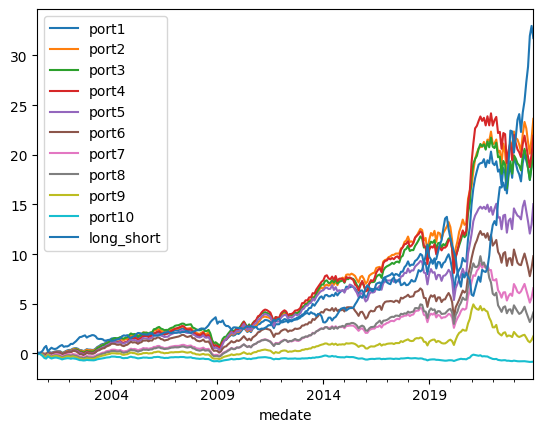

In [5]:
# Parte 5 - plotto

import matplotlib.pyplot as plt

# single criteria
factor='ns'
((1+portfolios[factor]).cumprod()-1).plot()



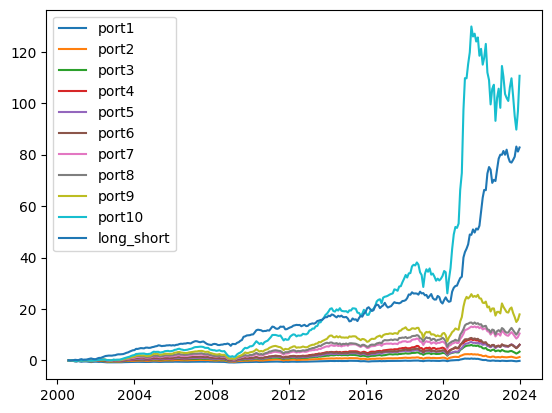

In [6]:
# mj
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['mj'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

In [7]:
# Parte 6 - creare portafogli mcdm 

from pymcdm.methods import TOPSIS, VIKOR, PROMETHEE_II
from pymcdm.weights import equal_weights


def compute_mcdm_rolling_strategy(df: pd.DataFrame, method_name: str, configuration: dict):
    """
    Calcola portafogli MCDM rolling mensili: 10 portafogli + long-short (EW) con turnover.
    Output compatibile con portfolios['nome'].
    
    Args:
        df: DataFrame con dati mensili normalizzati (include 'date', 'PERMNO', 'RET_RF', 'me_lag', e fattori).
        method_name: 'topsis', 'vikor', 'promethee'
        configuration: dizionario tipo MJ_configuration

    Returns:
        portfolios_df: DataFrame con colonne port1-port10, long_short
        turnover_df: DataFrame con turnover EW per ogni portafoglio
    """
    df = df.copy()
    df['medate'] = df['date'] + MonthEnd(0)

    # Parametri
    K = configuration['K']
    lag = configuration['lag']
    num_port = configuration['num_port']
    factors = configuration['factors']
    types = configuration['default_signs']
    verbose = configuration.get('verbose', False)

    # Metodo MCDM
    method_map = {
        'topsis': TOPSIS(),
        'vikor': VIKOR(v=0.5),
        'promethee': PROMETHEE_II(preference_function='usual')
    }
    assert method_name in method_map
    model = method_map[method_name]

    # Date di ribilanciamento
    reallocation_dates = []
    date_start = df['medate'].min() + MonthEnd(lag)
    date_end = df['medate'].max()
    while date_start + MonthEnd(K) <= date_end:
        reallocation_dates.append(date_start)
        date_start += MonthEnd(K)

    # Output: rendimenti per ciascun portafoglio
    returns_dict = {f'port{i+1}': [] for i in range(num_port)}
    returns_dict['long_short'] = []
    turnover = {f'port{i+1}': [] for i in range(num_port)}

    for date in reallocation_dates:
        df_now = df[df['medate'] == date].dropna(subset=factors).copy()
        if df_now.empty or len(df_now) < num_port:
            continue

        matrix = df_now[factors].values
        weights = equal_weights(matrix)

        ascending = True if method_name == 'vikor' else False
        scores = model(matrix, weights, types)
        df_now['score'] = scores
        df_now = df_now.sort_values('score', ascending=ascending).reset_index(drop=True)

        # Assegna portafogli
        df_now['portfolio'] = pd.qcut(df_now.index, q=num_port, labels=[f'port{i+1}' for i in range(num_port)])

        # Holding period
        period_end = date + MonthEnd(K)
        df_hold = df[(df['medate'] > date) & (df['medate'] <= period_end)]

        port_permnos = {}
        for port in [f'port{i+1}' for i in range(num_port)]:
            tickers = df_now[df_now['portfolio'] == port]['PERMNO'].tolist()
            port_permnos[port] = tickers
            df_port = df_hold[df_hold['PERMNO'].isin(tickers)]
            ret = df_port.groupby('medate')['RET_RF'].mean()
            returns_dict[port].append(ret)

        # Turnover EW
        for port in port_permnos:
            curr = set(port_permnos[port])
            if len(turnover[port]) > 0 and isinstance(turnover[port][-1][1], list):
                prev = set(turnover[port][-1][1])
                inter = len(prev & curr)
                total = max(len(prev), len(curr))
                t = 1 - (inter / total) if total > 0 else np.nan
            else:
                t = np.nan
            # salva sempre i ticker per il prossimo confronto
            turnover[port].append((date, port_permnos[port]))


        # Long-short
        long = df_hold[df_hold['PERMNO'].isin(port_permnos[f'port1'])]
        short = df_hold[df_hold['PERMNO'].isin(port_permnos[f'port{num_port}'])]
        ret_long = long.groupby('medate')['RET_RF'].mean()
        ret_short = short.groupby('medate')['RET_RF'].mean()
        ls_ret = ret_long - ret_short
        returns_dict['long_short'].append(ls_ret)

    # Concatena risultati
    for key in returns_dict:
        returns_dict[key] = pd.concat(returns_dict[key]).sort_index()

    portfolios_df = pd.DataFrame(returns_dict).dropna()

    # Calcola turnover medio
    turnover_df = {port: np.nanmean([x[1] for x in vals if isinstance(x[1], (int, float, np.float64))])
                   for port, vals in turnover.items()}

    return portfolios_df, turnover_df

portfolios['topsis'], topsis_turnover = compute_mcdm_rolling_strategy(df_norm, 'topsis', MJ_configuration)
portfolios['vikor'], vikor_turnover = compute_mcdm_rolling_strategy(df_norm, 'vikor', MJ_configuration)
portfolios['promethee'], promethee_turnover = compute_mcdm_rolling_strategy(df_norm, 'promethee', MJ_configuration)


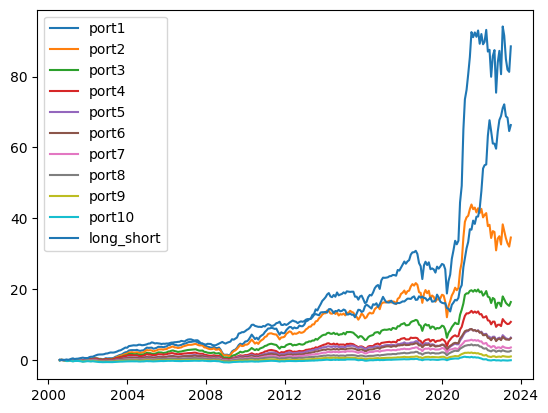

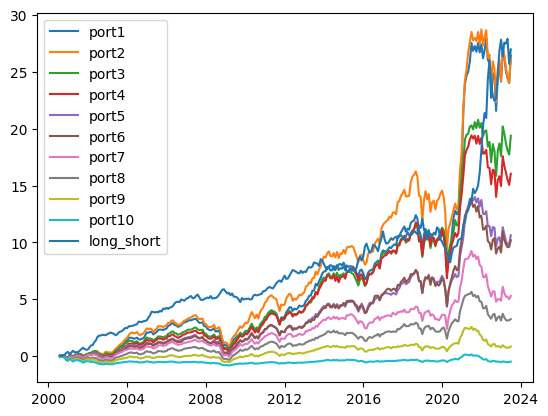

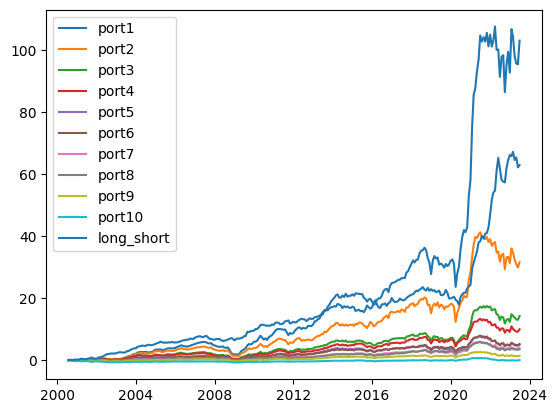

In [8]:
# topsis
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['topsis'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# vikor
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['vikor'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()

# promethee
for port in [f'port{i}' for i in range(1,MJ_configuration['num_port']+1)]+['long_short']:
    plt.plot(((1+portfolios['promethee'])[port].cumprod()-1),label=port)
plt.legend()
plt.show()


In [9]:
print("csv normale")
print(df[['beta', 'volatility', 'ns']].describe())
print()

print("csv vergine")
df = pd.read_csv("monthly_data.csv")
print(df[['beta', 'volatility', 'ns']].describe())
print()

print("csv normalizzato")
print(df_norm[['beta', 'volatility', 'ns']].describe())


csv normale
               beta    volatility            ns
count  1.099846e+06  1.098713e+06  1.093388e+06
mean   1.193127e+00  1.382054e-01  5.841085e-02
std    9.904235e-01  1.169586e-01  2.337955e-01
min   -2.034164e+01  2.060291e-03 -3.566472e+00
25%    5.589426e-01  7.161907e-02 -2.977445e-03
50%    1.055681e+00  1.079297e-01  7.011491e-03
75%    1.645929e+00  1.681334e-01  3.588503e-02
max    1.674717e+01  4.898001e+00  1.058958e+01

csv vergine
               beta    volatility            ns
count  1.099846e+06  1.098713e+06  1.093388e+06
mean   1.193127e+00  1.382054e-01  5.841085e-02
std    9.904235e-01  1.169586e-01  2.337955e-01
min   -2.034164e+01  2.060291e-03 -3.566472e+00
25%    5.589426e-01  7.161907e-02 -2.977445e-03
50%    1.055681e+00  1.079297e-01  7.011491e-03
75%    1.645929e+00  1.681334e-01  3.588503e-02
max    1.674717e+01  4.898001e+00  1.058958e+01

csv normalizzato
                beta     volatility             ns
count  879673.000000  879673.000000  87967

In [10]:
print("Metodo MJ:", MJ_configuration['method'])
print("Weighting:", MJ_configuration['weighting'])
print("Default signs:", MJ_configuration['default_signs'])
print("Rendimenti medi MJ:\n", portfolios['mj'].mean().sort_values())

Metodo MJ: majority
Weighting: False
Default signs: [-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, 1.0, -1.0, -1.0, -1.0, -1.0]
Rendimenti medi MJ:
 port1         0.002522
port2         0.005238
port3         0.007442
port4         0.009090
port6         0.009149
port5         0.009187
port7         0.010956
port8         0.011444
port9         0.012879
long_short    0.016875
port10        0.019397
dtype: float64


In [20]:
import dealib

for name in dir(dealib):
    attr = getattr(dealib, name)
    if callable(attr):
        print(f"🔍 Found callable: {name}")


🔍 Found callable: Efficiency
🔍 Found callable: Malmquist
🔍 Found callable: Orientation
🔍 Found callable: RTS
🔍 Found callable: add
🔍 Found callable: dea
🔍 Found callable: direct
🔍 Found callable: malmq
🔍 Found callable: mea
🔍 Found callable: sdea
🔍 Found callable: slack


🎯 Aziende utilizzate: 3020
✅ DEA completata. Esempio punteggi: [1.0, 1.0, 1.0, 1.0, 1.0]


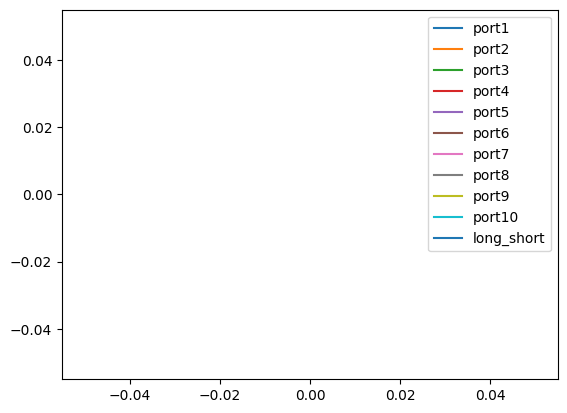

In [ ]:
def test_dea_add_for_single_date(df, configuration, date_str="2010-06-30"):
    import dealib

    # Prepara la data e i parametri
    date = pd.to_datetime(date_str)
    lag = configuration['lag']
    window = configuration['mj_window']
    factors = configuration['factors']
    types = configuration['default_signs']

    # Costruisci finestra rolling
    mask = (df['medate'] > date - MonthEnd(window)) & (df['medate'] <= date)
    df_test = df.loc[mask].copy()

    # Filtra aziende attive alla data
    permnos = df[df['medate'] == date]['PERMNO'].unique()
    df_test = df_test[df_test['PERMNO'].isin(permnos)]

    # Costruisci X e Y
    X = df_test[[f for f, t in zip(factors, types) if t == -1]]
    Y = df_test[[f for f, t in zip(factors, types) if t == 1]]
    mask = ~X.isnull().any(axis=1) & ~Y.isnull().any(axis=1)
    X, Y = X[mask].values, Y[mask].values

    print(f"🎯 Aziende utilizzate: {X.shape[0]}")
    if X.shape[0] == 0:
        print("⚠️ Nessuna azienda valida per DEA")
        return

    # Esegui DEA
    try:
        scores_obj = dealib.add(X, Y)
        scores = [float(s) for s in scores_obj.eff]
        print("✅ DEA completata. Esempio punteggi:", scores[:5])
    except Exception as e:
        print("❌ DEA fallita:", e)

test_dea_add_for_single_date(df_norm, MJ_configuration, date_str="2010-06-30")



In [30]:
for key in ['DEA', 'ADD.DEA']:
    portfolios.pop(key, None)




metodi = list(portfolios.keys())
best_portfolios = {}

for metodo in metodi:
    df_metodo = portfolios[metodo]
    rendimenti_medi = df_metodo.mean()
    best_port = rendimenti_medi.idxmax()
    best_rendimento = rendimenti_medi.max()

    best_portfolios[metodo] = {
        'portafoglio': best_port,
        'rendimento_medio': best_rendimento
    }

for metodo, info in best_portfolios.items():
    print(f"{metodo.upper():<10} --> {info['portafoglio']} con rendimento medio {info['rendimento_medio']:.4f}")

# Trova il miglior portafoglio tra tutti quelli già salvati
migliore_assoluto = max(best_portfolios.items(), key=lambda x: x[1]['rendimento_medio'])

metodo_top = migliore_assoluto[0]
portafoglio_top = migliore_assoluto[1]['portafoglio']
rendimento_top = migliore_assoluto[1]['rendimento_medio']
print("*" * 50)
print(f"WINNER: Il miglior portafoglio in assoluto è: {metodo_top.upper()} ➜ {portafoglio_top} con rendimento medio {rendimento_top:.4f}")


AG         --> port3 con rendimento medio 0.0132
BETA       --> port7 con rendimento medio 0.0113
BM         --> port10 con rendimento medio 0.0180
CUMRET     --> port1 con rendimento medio 0.0122
DOLVOL6    --> port1 con rendimento medio 0.0191
GP         --> port10 con rendimento medio 0.0128
ILL6       --> port10 con rendimento medio 0.0181
NS         --> long_short con rendimento medio 0.0143
SIZE       --> port1 con rendimento medio 0.0166
VOLATILITY --> port6 con rendimento medio 0.0113
ACC        --> port7 con rendimento medio 0.0109
MJ         --> port10 con rendimento medio 0.0194
TOPSIS     --> port1 con rendimento medio 0.0189
VIKOR      --> port2 con rendimento medio 0.0140
PROMETHEE  --> port1 con rendimento medio 0.0191
DEA        --> nan con rendimento medio nan
ADD.DEA    --> nan con rendimento medio nan
**************************************************
WINNER: Il miglior portafoglio in assoluto è: MJ ➜ port10 con rendimento medio 0.0194


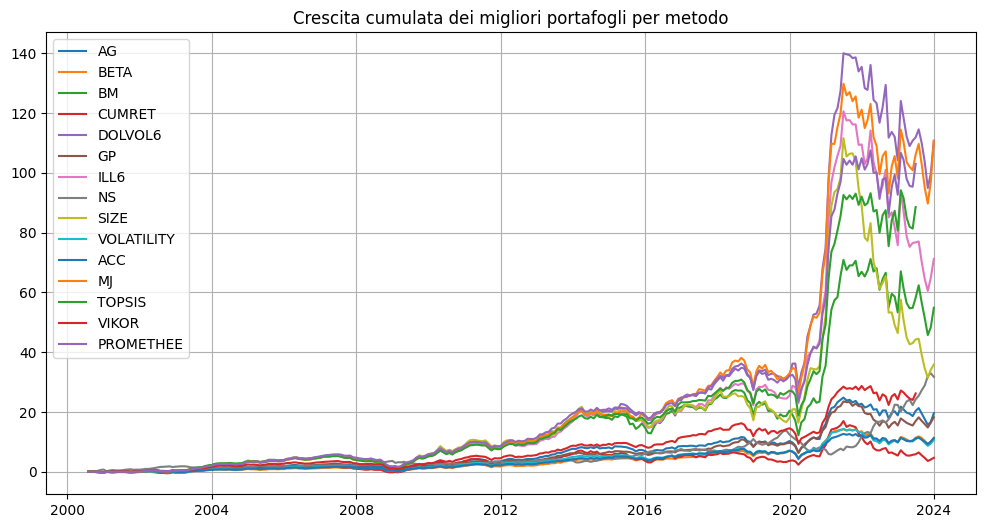

In [ ]:
# Plottare l'analisi sopra, quindi i portafogli migliori
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

for metodo, info in best_portfolios.items():
    serie = portfolios[metodo][info['portafoglio']]
    plt.plot(((1 + serie).cumprod() - 1), label=metodo.upper())

plt.legend()
plt.title('Crescita cumulata dei migliori portafogli per metodo')
plt.grid(True)
plt.show()


In [ ]:
# Fare pesato + vedere se mcdm sta prendendo 1 o 10 (deve prendere 10, non 1)
# Implementare add.DEA
# Aggiungere spider plot
